In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
from scipy import stats
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise import NormalPredictor, BaselineOnly, KNNBasic, KNNWithMeans, SVD, NMF, accuracy
from collections import defaultdict

In [2]:
# initialize data
item_threshold = 1 # used to filter out user/artist pairs that have been 
                   #listened to less than the threshold number of times
popular_artist_fraction = 0.2 # top cutoff for what we consider popular artists, in this case the top 20%

user_events_file = '../data/user_events.txt'
low_user_file = '../data/low_main_users.txt'
medium_user_file = '../data/medium_main_users.txt'
high_user_file = '../data/high_main_users.txt'

In [3]:
#read in user events file
cols = ['user', 'artist', 'album', 'track', 'timestamp']
df_events = pd.read_csv(user_events_file, sep='\t', names=cols)
print('No. of user events: ' + str(len(df_events)))
df_events.head() # check it is all read in properly

No. of user events: 28718087


,user,artist,album,track,timestamp
0,31435741,2,4,4,1385212958
1,31435741,2,4,4,1385212642
2,31435741,2,4,4,1385212325
3,31435741,2,4,4,1385209508
4,31435741,2,4,4,1385209191


In [4]:
# create unique user-artist matrix
df_events = df_events.groupby(['user', 'artist']).size().reset_index(name='count')
print('No. user-artist pairs: ' + str(len(df_events)))
# each row contains a unique user-artist pair, along with how many times the
# user has listened to the artist
df_events.head()

No. user-artist pairs: 1755361


,user,artist,count
0,1021445,12,43
1,1021445,16,1
2,1021445,28,7
3,1021445,29,1
4,1021445,46,1


In [5]:
# filters out artist/user pairs who havent been listened two more than
# item_threshold amount of times to reduce
# kept mostly to 1 so we dont filter out any data currently
df_events = df_events[df_events['count'] >= item_threshold] 

# With 1, we see no difference between user-artist pairs here
print('No. filtered user-artist pairs: ' + str(len(df_events))) 

# here, we see the number of unique artists in our matrix
print('No. unique artists: ' + str(len(df_events['artist'].unique())))

No. filtered user-artist pairs: 1755361
No. unique artists: 352805


In [6]:
# get matrix where each row is a user-id and how many artists they've 
#listened to
user_dist = df_events['user'].value_counts() 

# counts how many unique users there are. prints out user id & a count of how 
# many rows they're included in, which effectively shows how many artists 
# they listen to
num_users = len(user_dist)
print('Mean artists of all users: ' + str(user_dist.mean()))
print('Min artists of all users: ' + str(user_dist.min()))
print('Max artists of all users: ' + str(user_dist.max()))



Mean artists of all users: 585.1203333333333
Min artists of all users: 18
Max artists of all users: 4011


In [7]:
# get artist distribution
# same as previous but with artists, shows artist-id and how many times they
# were listened to buy unique users
artist_dist = df_events['artist'].value_counts()
num_artists = len(artist_dist)
print('No. artists: ' + str(num_artists))
df_events['artist'].value_counts().head

No. artists: 352805


<bound method NDFrame.head of 135        1389
1602       1359
46         1325
320        1297
27         1290
           ... 
3124286       1
1029181       1
1023032       1
1008679       1
3087545       1
Name: artist, Length: 352805, dtype: int64>

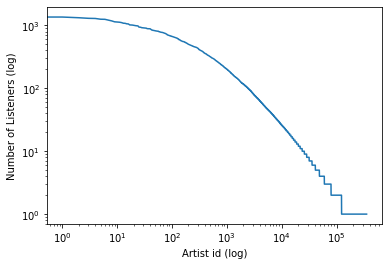

In [8]:
#plots x,y pairs of each row
# x is the artist id, y is the number of listeners 
# log both axes for feature scaling purposes
plot.plot(artist_dist.values)
plot.xlabel('Artist id (log)')
plot.ylabel('Number of Listeners (log)')
plot.xscale("log")
plot.yscale("log")

In [9]:
# get number of  popular artists
num_top_artists = int(popular_artist_fraction * num_artists)

# getting the top top_fraction (0.2) percent of artists, so finding how many
# artists make up 20% of total artists, and then only using the artists those
#number of the most popular aritsts
top_artist_dist = artist_dist[:num_top_artists]
print('No. top artists: ' + str(len(top_artist_dist)))

No. top artists: 70561


In [10]:
# read in users
# user file is just user_id and their mainstreaminess value 
low_users = pd.read_csv(low_user_file, sep=',').set_index('user_id')
medium_users = pd.read_csv(medium_user_file, sep=',').set_index('user_id')
high_users = pd.read_csv(high_user_file, sep=',').set_index('user_id')
no_users = len(low_users) + len(medium_users) + len(high_users)
print('No. of users: ' + str(no_users))

No. of users: 3000


In [11]:
low_users.head()

,M_global_R_APC
user_id,
20146143,-0.260074
32463394,-0.253610
47706954,-0.236572
19772905,-0.215595
21128139,-0.199496


In [12]:
# get popularity metrics
pop_count = [] # number of top items per user
user_hist = [] # user history sizes
pop_fraq = [] # relative number of top items per user
pop_artist_fraq = [] # average popularity of items in user profiles
low_profile_size = 0
low_gap_p = 0
medium_profile_size = 0
medium_gap_p = 0
high_profile_size = 0
high_gap_p = 0
low_count = 0
med_count = 0
high_count = 0
for u, df in df_events.groupby('user'):
    no_user_artists = len(set(df['artist'])) # profile size //number of artists in users profile
    # top items in profile //top percent of pop artists in users profile
    no_user_pop_artists = len(set(df['artist']) & set(top_artist_dist.index)) 
    pop_count.append(no_user_pop_artists) # adds users # of pop artists to a list 
    user_hist.append(no_user_artists) #sizes of users listening histories
    pop_fraq.append(no_user_pop_artists / no_user_artists) #fraction of pop items in profile / total items
    # get popularity (= fraction of users interacted with item) of user items and calculate average of it
    user_pop_artist_fraq = sum(artist_dist[df['artist']] / no_users) / no_user_artists
    pop_artist_fraq.append(user_pop_artist_fraq)
    if u in low_users.index: # get user group-specific values
        low_profile_size += no_user_artists
        low_gap_p += user_pop_artist_fraq
        low_count += 1
    elif u in medium_users.index:
        medium_profile_size += no_user_artists
        medium_gap_p += user_pop_artist_fraq
        med_count += 1
    else:
        high_profile_size += no_user_artists
        high_gap_p += user_pop_artist_fraq
        high_count += 1
low_profile_size /= len(low_users)
medium_profile_size /= len(medium_users)
high_profile_size /= len(high_users)
low_gap_p /= len(low_users) # average popularity of items/artists in low/med/high groups (gap = group average popularity)
medium_gap_p /= len(medium_users)
high_gap_p /= len(high_users)
print('Low count (for check): ' + str(low_count))
print('Med count (for check): ' + str(med_count))
print('High count (for check): ' + str(high_count))


Low count (for check): 1000
Med count (for check): 1000
High count (for check): 1000


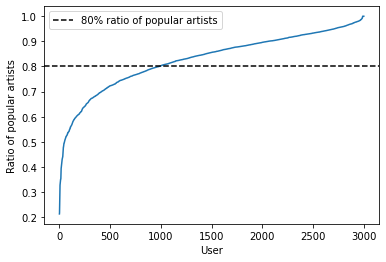

In [13]:
plot.figure()
plot.plot(sorted(pop_fraq))
plot.xlabel('User')
plot.ylabel('Ratio of popular artists')
plot.axhline(y=0.8, color='black', linestyle='--', label='80% ratio of popular artists')
plot.legend()

Text(0, 0.5, 'Number of popular artists')

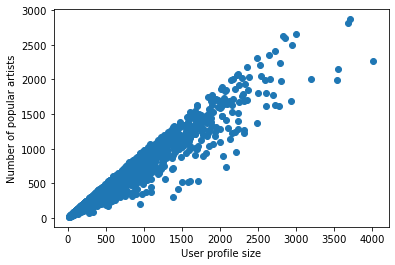

In [14]:
plot.figure()
plot.plot(user_hist, pop_count, 'o')
plot.xlabel('User profile size', )
plot.ylabel('Number of popular artists')

Text(0, 0.5, 'Average popularity of artists')

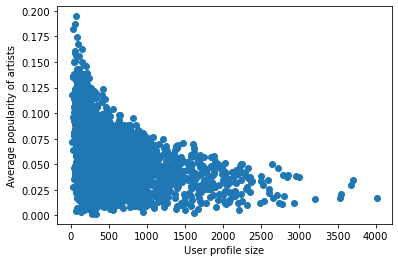

In [15]:
plot.figure()
#line = slope * np.array(user_hist) + intercept
plot.plot(user_hist, pop_artist_fraq, 'o')
plot.xlabel('User profile size')
plot.ylabel('Average popularity of artists')

In [16]:
print('Average LowMS profile size: ' + str(low_profile_size))
print('Average MedMS profile size: ' + str(medium_profile_size))
print('Average HighMS profile size: ' + str(high_profile_size))

Average LowMS profile size: 499.892
Average MedMS profile size: 715.669
Average HighMS profile size: 539.8


In [17]:
### Now its time for the fun shit

In [18]:
### Figure out how to scale listening count
scaled_df_events = pd.DataFrame()
for user_id, group in df_events.groupby('user'):
    #print(group)
    min_listens = group['count'].min()
    max_listens = group['count'].max()
    std = (group['count'] - min_listens) / (max_listens - min_listens)
    scaled_listens = std * 999 + 1
    to_replace = group.copy()
    to_replace['count'] = scaled_listens
    #print(to_replace)
    scaled_df_events = scaled_df_events.append(to_replace)
scaled_df_events.head()   
#df_events.groupby('user').head()
#pogChamp

,user,artist,count
0,1021445,12,184.222707
1,1021445,16,1.000000
2,1021445,28,27.174672
3,1021445,29,1.000000
4,1021445,46,1.000000


In [19]:
#scaled_df_events = scaled_df_events.set_index('user')
scaled_df_events.head()

,user,artist,count
0,1021445,12,184.222707
1,1021445,16,1.000000
2,1021445,28,27.174672
3,1021445,29,1.000000
4,1021445,46,1.000000


In [20]:
df_events = scaled_df_events
print('Min rating: ' + str(df_events['count'].min()))
print('Max rating: ' + str(df_events['count'].max()))

Min rating: 1.0
Max rating: 1000.0


In [21]:
reader = Reader(rating_scale=(1,1000))
data = Dataset.load_from_df(df_events,reader)

In [22]:
# to my knowledge random_state doesnt matter as long as its some number?
trainset, testset = train_test_split(data, test_size = 0.2, random_state=5) 
# maybe dont use? trying cv first

In [23]:
def get_top_artists(predictions, num):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """
    top_artists_dict = defaultdict(list)
        # creating dictionary where user id is the key, and the val is a list of tuples of the artist id and 
        # the rating it thinks the user would give it
        
    for user_id, artist_id, actual_val, predicted_val, details in predictions:
        top_artists_dict[user_id].append((artist_id,predicted_val))
        
    #sorts user ratings based off of the predicted val rating and get the top n rated artists
    
    for user_id, ratings in top_artists_dict.items():
        ratings.sort(key = lambda x: x[1], reverse=True)
        top_artists_dict[user_id] = ratings[:num]
    return top_artists_dict
        
        

In [24]:
def get_mae_of_groups(predictions):
    predictions_low = []
    predictions_medium = []
    predictions_high = []
    
    for prediction_obj in predictions:
        if prediction_obj.uid in low_users.index:
            predictions_low.append(prediction_obj)
            
        elif prediction_obj.uid in medium_users.index:
            predictions_medium.append(prediction_obj)
            
        elif prediction_obj.uid in high_users.index:
            predictions_high.append(prediction_obj)
        
    mae_low = accuracy.mae(predictions_low)
    mae_medium = accuracy.mae(predictions_medium)
    mae_high = accuracy.mae(predictions_high)
            
    print("Low Predictions:", mae_low)
    print("Med Predictions: ", mae_medium)
    print("High Predictions: ", mae_high)
    
    return mae_low, mae_medium, mae_high
            

In [30]:
low_gap_r_list = []
medium_gap_r_list = []
high_gap_r_list = []

low_mae_list = []
medium_mae_list = []
high_mae_list = []
overall_mae_list = []
#for alg in [ BaselineOnly(), KNNBasic(sim_options = {'name': 'msd'}), KNNWithMeans(), NMF()]:
for alg in [BaselineOnly()]:

    base = alg.fit(trainset)
    predictions = base.test(testset)
    overall_mae = accuracy.mae(predictions)
    # calculate gap as test
    low_gap_r = 0
    medium_gap_r = 0
    high_gap_r = 0

    num_low_users = 0
    num_medium_users = 0
    num_high_users = 0
    
    low_mae = 0
    medium_mae = 0
    high_mae = 0
    top_artists = get_top_artists(predictions, 10)
    low_mae, medium_mae, high_mae = get_mae_of_groups(predictions)
    
    low_mae_list.append(low_mae)
    medium_mae_list.append(medium_mae)
    high_mae_list.append(high_mae)
    overall_mae_list.append(overall_mae)

    for user_id, ratings in top_artists.items():
        artist_id_list = []
        print(ratings)
        for artist_id, predicted_rating in ratings:
            
            artist_id_list.append(artist_id)

        gap = sum(artist_dist[artist_id_list]/ no_users) / len(artist_id_list) #not full gap
        print(len(artist_id_list))
        #print("gap:" ,gap)
        if user_id in low_users.index:
            low_gap_r += gap
            num_low_users += 1

        elif user_id in medium_users.index:
            medium_gap_r += gap
            num_medium_users += 1

        elif user_id in high_users.index:
            high_gap_r += gap
            num_high_users += 1
    low_gap_r = low_gap_r / num_low_users
    medium_gap_r = medium_gap_r / num_medium_users
    high_gap_r = high_gap_r / num_high_users
    
    low_gap_r_list.append(low_gap_r)
    medium_gap_r_list.append(medium_gap_r)
    high_gap_r_list.append(high_gap_r)

    


    

Estimating biases using als...
MAE:  38.6072
MAE:  43.0801
MAE:  34.2366
MAE:  40.2892
Low Predictions: 43.0800838064358
Med Predictions:  34.23659494771558
High Predictions:  40.28919680447999
[(9179, 187.99023713992503), (3263, 180.72000648176052), (2758, 179.79405332283477), (79317, 174.46608113077156), (185, 169.42059656069083), (7047, 165.4413949720939), (16244, 164.51321545478615), (3013, 160.0240284847055), (36, 159.97757445119743), (4207, 156.05712652245631)]
10
[(46, 118.12621947107318), (5619, 107.31697544924367), (8773, 102.51481416408949), (8132, 101.25039340639245), (471, 97.63787878424922), (6205, 95.44274360127808), (15000, 93.7156569671163), (2539, 93.64370984941714), (3, 92.9695869047712), (2988, 90.42106108620484)]
10
[(368, 164.23448660622896), (14806, 108.2919940505175), (14995, 101.58210791718038), (32, 97.41402208054022), (46, 97.31704168953554), (14783, 95.38417173457884), (99, 87.95338918314518), (15217, 78.36283911735202), (1696, 75.41691489042594), (248, 74.41

10
[(6872, 103.16952694625273), (55, 98.69562005899465), (438, 86.25232432280615), (27, 82.26516767517515), (301, 81.09987364527508), (8852, 79.33449657516486), (8314, 75.40940454197232), (137, 73.28928192600395), (51, 73.15935087046836), (1696, 70.61042245264494)]
10
[(7857, 129.9369282743295), (5379, 113.49136869563142), (71, 111.30388490286452), (7395, 110.30010882274232), (3909, 100.81051523451964), (5333, 99.36685800635442), (8764, 96.7406659921833), (445, 96.20044339416512), (2689, 94.09371177610825), (6249, 92.50614657729017)]
10
[(55, 98.08444794746107), (27, 81.65399556364157), (80005, 76.13312681956954), (8314, 74.79823243043874), (6249, 72.68681848476315), (295, 67.99927634972885), (3744, 65.11031226861304), (15707, 63.56003924231166), (1680, 55.013091082514876), (4377, 51.49518542123036)]
10
[(7929, 249.98168363052685), (57463, 240.39994857600067), (11567, 230.47426742210644), (56969, 222.51408857272824), (6426, 217.98276279765017), (7927, 217.3792688078417), (30366, 206.79

10
[(3019, 127.46511327848816), (32, 126.07423229568175), (2539, 101.49474228302103), (135, 101.0503768856995), (3724, 98.42541420024945), (2923, 94.88378850465976), (406, 90.43525065521922), (1708, 87.9635589116132), (17227, 86.43770247165061), (17414, 84.15670118946495)]
10
[(978, 127.55312094655349), (6872, 111.64651894777384), (301, 89.5768656467962), (2824, 69.30559581400038), (14141, 63.003848858655495), (517, 60.63699055619943), (13238, 56.25618904175353), (2807, 46.28645186611506), (2820, 44.998916722189826), (10287, 44.580108129576246)]
10
[(14858, 87.3874147354201), (14794, 86.36863570892136), (8988, 85.66655787167666), (425, 69.4745086903738), (27595, 59.10898198681488), (139, 55.004042656988915), (8926, 50.91343366524768), (21995, 48.55057723649426), (27166, 46.959337230961744), (14141, 45.28812995215817)]
10
[(4115, 110.59563290498552), (157647, 88.76292073654957), (461, 86.07894902039608), (29069, 84.67226321171893), (180401, 82.56053049108566), (49480, 79.59831639181394)

[(4115, 111.38779604777758), (283, 97.05185889842681), (6234, 93.5316919999349), (153, 89.3862987262138), (14298, 89.3036860077795), (5619, 79.71790086377496), (1696, 68.62701808649487), (3561, 67.63259121712275), (4668, 67.10269320071284), (185, 63.89720288673436)]
10
[(368, 165.15749979129487), (4115, 119.10070603677455), (18273, 106.02860744186825), (283, 104.76476888742378), (470, 89.56075777827158), (27, 87.99467329802205), (2758, 81.98356963787528), (1696, 76.33992807549184), (1, 75.50124019300243), (295, 74.33995408410932)]
10
[(301, 110.26018422541102), (16, 109.56809784251257), (18159, 107.42239483052253), (14871, 106.76186820432268), (405, 103.08965621170424), (6249, 102.45830117643267), (7049, 93.398160087608), (16900, 91.15925081229156), (1677, 91.03852857332993), (2442, 90.28298390354809)]
10
[(6872, 112.85289189704493), (8988, 104.58864972744507), (2868, 102.93935366305467), (153, 101.05306804315605), (383, 96.84271965689922), (425, 88.39660054614221), (12987, 87.91520685

10
[(14664, 127.97005787412898), (54, 126.86501356269898), (6395, 123.83239035030451), (51736, 122.3901924914713), (2353, 113.07854501221681), (10265, 112.21845533382107), (7395, 105.3219095916011), (5608, 102.06648929861475), (3716, 97.9888399759822), (384, 97.3031644138918)]
10
[(3744, 54.40283244143613), (35746, 53.790901164484566), (2988, 53.48673892817571), (5974, 52.9929476369242), (139, 52.92411762325463), (10028, 36.31474239773037), (163, 35.872128002670664), (801, 34.22415874822845), (52132, 27.158470498194696), (4991, 26.849587738473634)]
10
[(1602, 133.760348075649), (883, 90.3306821849977), (135, 77.43098341071459), (7487, 74.45208405332828), (238, 74.33217470828617), (139, 74.09007873990275), (2562, 70.67023786492274), (1671, 70.50295740292682), (5175, 69.03804364228914), (2478, 65.48803921219593)]
10
[(32, 130.01387140018363), (7, 117.52765610486347), (9873, 110.28762754041227), (471, 109.428550322355), (129, 109.13608146794238), (1705, 106.19823535102367), (4206, 106.105

10
[(55, 90.2605358498542), (740, 76.99138817389561), (4081, 73.51943865223615), (16, 71.97270305323619), (249, 69.014427317454), (52553, 65.4996493828966), (379, 64.44921854803955), (576, 58.263776763651954), (424, 55.68239909026148), (8775, 53.00675841611362)]
10
[(79470, 75.4626992392502), (15707, 64.36049767664208), (21745, 59.95952899172339), (227, 58.89533729835374), (13556, 57.59143081725844), (14048, 56.37478860781766), (9347, 55.52517891095454), (13300, 53.21320177577469), (16151, 49.33332670822911), (14082, 48.6323154509401)]
10
[(4112, 112.56102648348823), (43624, 101.34116411091003), (6234, 96.18010718192733), (3019, 94.66342144140796), (32, 93.27254045860155), (39439, 85.20568083866138), (330, 81.7962594427938), (16, 81.072798078219), (279, 79.92696652814533), (379, 73.54931357302236)]
10
[(2796, 117.17328637913455), (54, 110.44877965665945), (470, 81.64497499923736), (99, 80.96061958917686), (97413, 79.03621043300002), (7, 77.93503719125174), (249, 75.26323437040715), (37

10
[(8040, 73.71712147806612), (6379, 69.40510080709217), (8408, 66.45185660262909), (3916, 54.1644197715175), (13825, 51.838323090065714), (2967, 49.98447964223139), (10395, 48.61002808375417), (1807, 48.30245169983523), (16295, 45.8367813933379), (417, 44.96573105111027)]
10
[(32, 90.87380375107799), (9718, 84.03322437396281), (5619, 79.96757933824378), (67636, 72.62583824748675), (1705, 67.05816770191802), (2986, 63.95949472744223), (3031, 54.29883056092378), (3881, 49.296491640334224), (353, 47.36934383475049), (1650, 47.31960185231603)]
10
[(9178, 120.62948514758423), (4, 102.03826890364667), (172, 91.28806482172504), (8996, 89.69411833743025), (17351, 87.05778309365103), (379, 79.4054152345577), (1314, 78.69268781100226), (6014, 76.96526241907011), (17421, 75.87891551301587), (295, 75.1315609386401)]
10
[(2353, 105.49450426802304), (15154, 87.95582057930494), (16, 87.0537032680351), (4117, 80.71253656251922), (137, 79.9351979316624), (1696, 77.25633845830338), (424, 70.7633993050

10
[(6872, 183.96054633754244), (27, 163.05618706646487), (301, 161.89089303656482), (2822, 151.17005235248124), (3, 148.14493607674228), (6940, 144.22571730834468), (374, 137.63872426361038), (13317, 133.7689127887338), (9334, 132.5339628123734), (14553, 116.52689181850994)]
10
[(54, 94.84318833804873), (1514, 70.15729216559784), (80660, 68.38340294758143), (3, 49.56204821065453), (14085, 33.991008942490325), (57, 31.482612970488383), (1702, 28.982954437727145), (3912, 26.64753297889388), (3141, 23.322852842500602), (32667, 19.015978624435867)]
10
[(43977, 129.685104261042), (471, 113.20993346606515), (3, 108.54164158658713), (1358, 90.98636273793451), (1700, 81.40542829289632), (28464, 78.60854944174808), (28039, 73.11535647010686), (4696, 71.07373906656727), (28482, 65.72234087251252), (103716, 63.335594705573605)]
10
[(3019, 101.01022618170462), (330, 88.14306418309046), (16, 87.41960281851564), (405, 80.9411611877073), (16900, 69.01075578829463), (86101, 60.219693346927876), (79, 

10
[(5608, 96.53013267784624), (353, 57.79666985551542), (49353, 56.6917120608916), (163, 55.88438007046485), (86997, 54.00126231431756), (1681, 50.41488340418576), (7582, 48.6417836687222), (86096, 47.376841749194604), (9529, 46.92153177933605), (20432, 46.16800099639599)]
10
[(9477, 55.256151439713875), (146025, 32.432490815586505)]
2
[(4115, 116.98698506425751), (1339, 109.00699120743118), (35597, 101.04145082188808), (8, 100.47369550251793), (7403, 99.05544913471712), (1514, 91.56494529072572), (470, 87.44703680575452), (4081, 85.57030751170646), (3909, 85.21814390385606), (210, 83.53801194800499)]
10
[(283, 131.1933857976051), (470, 115.98937468845288), (137, 105.44740445903216), (185, 98.03872978591264), (2988, 96.9635133999144), (131808, 95.75922181621664), (1677, 94.03634052622219), (360, 88.73302907606606), (504, 87.44807972928892), (13243, 84.51879102756472)]
10
[(1602, 132.06033313635572), (3019, 102.14570486420996), (28743, 73.00417078307756), (140, 70.80332847990314), (260

10
[(289, 81.11238926908571), (2443, 74.55116025618386), (470, 74.03498779058664), (7929, 70.52954493654019), (41435, 66.72586693819646), (12808, 53.95354716702995), (5045, 53.59155551849729), (85, 48.2786439327903), (10402, 45.7000161267198), (5209, 44.82401567905339)]
10
[(28802, 108.95631225288032), (4558, 88.39079634233902), (245, 82.02608510699335), (40947, 80.39185825136995), (1696, 79.203674141004), (3744, 74.31473606850568), (140, 71.24928592961786), (37829, 70.32112509609675), (10523, 63.451230968626675), (27750, 62.915331337537694)]
10
[(153, 85.18422639287205), (1648, 78.3195965336706), (691, 47.7389841058574), (80574, 47.45702616608432), (28, 43.3855061486088), (8681, 41.66687988436895), (4667, 39.32626118632082), (51761, 36.514421316551406), (9557, 36.13413746388568), (2697, 34.4619788972611)]
10
[(368, 173.07459479694643), (153, 105.01630372086234), (330, 94.77784925544995), (135, 81.23027486127546), (2986, 79.33982124762196), (2570, 74.29412091236296), (18899, 70.4082157

10
[(289, 92.3725344871371), (301, 82.56375449848844), (136, 81.60349616672862), (249, 78.91339237980782), (35685, 73.27171590341305), (231, 62.25852201779033), (4166, 58.19194161782303), (36, 57.90146599660439), (508, 57.34047248205107), (4207, 53.98101806786329)]
10
[(1339, 110.8967141787903), (171, 107.57306819767427), (8, 102.36341847387705), (15093, 87.47828284676515), (17817, 86.29964128855381), (8853, 85.31618695546695), (169, 83.63182225574116), (36396, 80.21537349223999), (10582, 78.96293998067785), (6766, 77.12681449800733)]
10
[(1648, 126.92844945733569), (4081, 124.3778990855499), (2549, 96.40134260242473), (9539, 92.75335699338598), (2111, 84.8430895955035), (1469, 82.31461802944747), (8639, 79.3198052475566), (6393, 77.5003712048986), (14252, 76.01263289779558), (8409, 75.16981095312387)]
10
[(1339, 91.16846921364838), (283, 84.81252592112392), (243, 79.41704319011106), (2195039, 79.36740216104454), (48678, 72.96072042881751), (402, 66.37946929522589), (30627, 66.12415821

[(4115, 161.53626618130616), (4, 143.68222219364748), (3, 115.51898245283107), (2478, 103.8057958016368), (4607, 99.66420535402575), (6198, 99.16795900998684), (28821, 95.84403574924808), (57336, 89.18411047394133), (1760, 87.02448944909665), (29203, 85.39630943436575)]
10
[(8, 123.17942287125084), (3909, 107.92387127258897), (7, 106.4428263665018), (5778, 94.11264819485729), (59, 90.2596720956884), (6779, 79.00226531782154), (517, 78.48151057374108), (3424, 67.29702550683962), (37, 61.14348618478803), (4025, 50.722060411823364)]
10
[(45, 90.17496688036098), (185, 86.22427709129089), (2988, 85.14906070529267), (424, 84.4611531378084), (28572, 72.16425492317398), (350, 69.03449130999675), (1649, 66.48968480957018), (520, 65.02450484206766), (2552, 64.37936092399315), (2762, 59.29054665695172)]
10
[(3019, 149.37548034800156), (2866, 148.42854613121807), (71, 147.47279864430703), (383, 142.53642442854294), (14134, 137.97230307163528), (499, 136.88468570733727), (16, 135.78485698481256), (

In [26]:
delta_gap_low_list = []
delta_gap_medium_list = []
delta_gap_high_list = []
for i in range(len(low_gap_r_list)):
    delta_gap_low = ((low_gap_r_list[i] - low_gap_p) / low_gap_p)
    delta_gap_medium = ((medium_gap_r_list[i] - medium_gap_p) / medium_gap_p)
    delta_gap_high = ((high_gap_r_list[i] - high_gap_p) / high_gap_p)
    
    delta_gap_low_list.append(delta_gap_low)
    delta_gap_medium_list.append(delta_gap_medium)
    delta_gap_high_list.append(delta_gap_high)

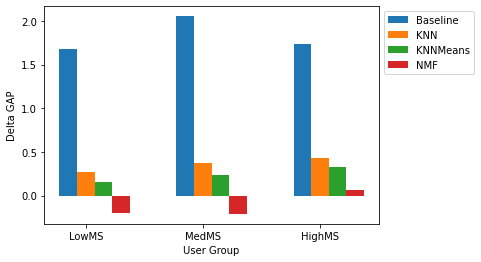

In [27]:
x_labels = ["LowMS", "MedMS", "HighMS"]
width = 0.15

bar1 = [delta_gap_low_list[0], delta_gap_medium_list[0], delta_gap_high_list[0]]
bar2 = [delta_gap_low_list[1], delta_gap_medium_list[1], delta_gap_high_list[1]]
bar3 = [delta_gap_low_list[2], delta_gap_medium_list[2], delta_gap_high_list[2]]
bar4 = [delta_gap_low_list[3], delta_gap_medium_list[3], delta_gap_high_list[3]]

x1 = np.arange(3) #low/md/and high
x2 = [i+width for i in x1]
x3 = [i+width for i in x2]
x4 = [i+width for i in x3]
plot.bar(x1, bar1, width = 0.15, label ="Baseline")
plot.bar(x2, bar2, width = 0.15, label ="KNN")
plot.bar(x3, bar3, width = 0.15, label ="KNNMeans")
plot.bar(x4, bar4, width = 0.15, label ="NMF")

plot.xlabel("User Group")
plot.ylabel("Delta GAP")
plot.legend(bbox_to_anchor=(1,1), loc="upper left", ncol=1)
plot.xticks(x1 + width, x_labels)
plot.show()